# 1 . Euler approximation of UHMR system

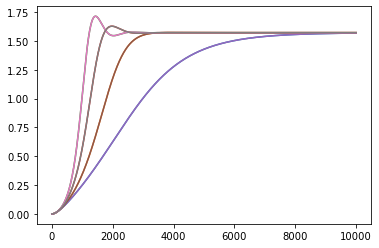

In [1]:
%clear
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from Euler_approximation import euler

[a1,a2,a3,a4]=[20,40,60,80] 
[phi1_a1,phi2_a1]=euler(a1)
[phi1_a2,phi2_a2]=euler(a2)
[phi1_a3,phi2_a3]=euler(a3)
[phi1_a4,phi2_a4]=euler(a4)


plt.plot(phi1_a1)
plt.plot(phi1_a2)
plt.plot(phi1_a4)
plt.plot(phi1_a3)

Text(0, 0.5, 'Angular velocity')

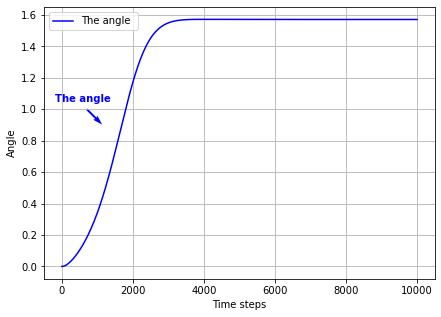

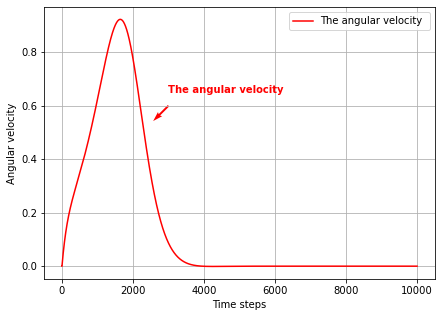

In [2]:
#  Plot the angle and angular velocity when 
plt.figure(figsize=(7,5))
plt.plot(phi1_a2,"b",label="The angle ")
plt.legend()
plt.text(-200,1.05,"The angle",weight="bold",color="blue")
plt.quiver(700, 1, 1, -1, color='b', width=0.005)
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Angle")

plt.figure(figsize=(7,5))
plt.plot(phi2_a2,"r",label="The angular velocity ")
plt.legend()
plt.text(3000,0.65,"The angular velocity",weight="bold",color="red")
plt.quiver(3000, 0.6, -1, -1, color='r', width=0.005)
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Angular velocity")

# 2. Data pre-processing.




## 2. 1 Pre-process the training datasets
Using four sets of magnetic field strength 20Oe, 40Oe,60Oe, 80Oe. a=[20,40,60,80].


In [3]:
[a1,a2,a3,a4]=[20,40,60,80] # four sets of magnetic field strength 
 # Get data sequence through Euler approximatiion
[phi1_a1,phi2_a1]=euler(a1)
[phi1_a2,phi2_a2]=euler(a2)
[phi1_a3,phi2_a3]=euler(a3)
[phi1_a4,phi2_a4]=euler(a4)

split_time =8000
T=10000
di=0.001
#Put all angle sequence together
phi1_all=np.concatenate((phi1_a1[:split_time],phi1_a2[:split_time],phi1_a3[:split_time],phi1_a4[:split_time]),axis=0)

 # Calculate the angular velocity
phi2_a1[:split_time]=(phi1_a1[1:split_time+1]-phi1_a1[:split_time])/di
phi2_a2[:split_time]=(phi1_a2[1:split_time+1]-phi1_a2[:split_time])/di
phi2_a3[:split_time]=(phi1_a3[1:split_time+1]-phi1_a3[:split_time])/di
phi2_a4[:split_time]=(phi1_a4[1:split_time+1]-phi1_a4[:split_time])/di
phi2_all=np.concatenate((phi2_a1[:split_time],phi2_a2[:split_time],phi2_a3[:split_time],phi2_a4[:split_time]),axis=0)

 # Calculate the angular acceleration
phi2_diff_all=np.concatenate((phi2_a1[1:split_time+1]-phi2_a1[:split_time],phi2_a2[1:split_time+1]-phi2_a2[:split_time],
                              phi2_a3[1:split_time+1]-phi2_a3[:split_time],phi2_a4[1:split_time+1]-phi2_a4[:split_time]),axis=0)
phi2_diff_all=phi2_diff_all/di

# Get the control input sequence 
input_a1=a1*np.ones(T)
input_a2=a2*np.ones(T)
input_a3=a3*np.ones(T)
input_a4=a4*np.ones(T)
input=np.concatenate((input_a1[:split_time],input_a2[:split_time],input_a3[:split_time],input_a4[:split_time]),axis=0)
 
# Stack all data together
series_input=np.stack((phi1_all,phi2_all,input,phi2_diff_all),axis=1)
series_input=series_input.reshape(4*split_time,4)

#Shuffle data for avioding overfitting
series_input=tf.random.shuffle(series_input)

x_train=series_input[:,0:3] # Training input dataset
y_train=series_input[:,3] # Training output dataset


## 2. 2 Pre-process the validation dataset
Using the magnetic field strength 50Oe. a=50.

In [7]:
a=50 # 
[phi1_valid,phi2_valid]=euler(a)

split_time =5000

 # Calculate the angular acceleration
phi2_diff_valid=(phi2_valid[1:split_time+1]-phi2_valid[:split_time])/di

# Get the control input sequence 
input_valid=a*np.ones(T)

# Stack all data together
series_input=np.stack((phi1_valid[:split_time],phi2_valid[:split_time],input_valid[:split_time],phi2_diff_valid),axis=1)
series_input=series_input.reshape(split_time,4)

#Shuffle data for avioding overfitting
series_input=tf.random.shuffle(series_input)
 
x_valid=series_input[:,0:3] # Validation input dataset
y_valid=series_input[:,3]  # Validation output dataset


# 3. Train FFNN

In [47]:
MAE_all = np.ones((1, 10)).squeeze()
for seed in range(10):  #Try different seed and the get the best one.     
        tf.random.set_seed(5+seed*5)
        print("seed=%d"%(5+seed*5))
        model = tf.keras.Sequential([tf.keras.layers.Dense(60,kernel_initializer='glorot_uniform',activation="elu"),
                                     tf.keras.layers.Dense(30,kernel_initializer='glorot_uniform', activation="elu"),
                                     tf.keras.layers.Dense(1)])

        optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)

        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])

        class CustomCallbacks(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
              if(logs.get('mae')<0.1):
                print("\n 99% acc reached")
                self.model.stop_training = True

        history= model.fit(x_train, y_train, epochs=800, callbacks=[CustomCallbacks()],verbose=1)
        trainPredict = model.predict(x_train)
        error=np.abs(trainPredict[:,0]*0.001-y_train*0.001)
        MAE_all[seed]=np.mean(error)  # the mean absolute error
       
        if MAE_all[seed]==np.min(MAE_all):
            model.save('Models/FFNN.h5')
            m=seed

seed=5
Epoch 1/800

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1000/1000 [==============================] - 0s 306us/step - loss: 0.3262 - mae: 0.5203
Epoch 2/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.2475 - mae: 0.4278
Epoch 3/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.2386 - mae: 0.4243
Epoch 4/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.2337 - mae: 0.4203
Epoch 5/800
1000/1000 [==============================] - 0s 340us/step - loss: 0.2275 - mae: 0.4082
E

1000/1000 [==============================] - 0s 315us/step - loss: 0.1320 - mae: 0.2763
Epoch 75/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.1426 - mae: 0.2910
Epoch 76/800
1000/1000 [==============================] - 0s 332us/step - loss: 0.1440 - mae: 0.2897
Epoch 77/800
1000/1000 [==============================] - 0s 328us/step - loss: 0.1245 - mae: 0.2679
Epoch 78/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.1342 - mae: 0.2758
Epoch 79/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.1156 - mae: 0.2543
Epoch 80/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.1167 - mae: 0.2551
Epoch 81/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.1340 - mae: 0.2730
Epoch 82/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.1625 - mae: 0.2978
Epoch 83/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.1391 - mae: 0.2777
Epo

1000/1000 [==============================] - 0s 315us/step - loss: 0.0858 - mae: 0.2423
Epoch 155/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0786 - mae: 0.2257
Epoch 156/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0744 - mae: 0.2143
Epoch 157/800
1000/1000 [==============================] - 0s 329us/step - loss: 0.0691 - mae: 0.2062
Epoch 158/800
1000/1000 [==============================] - 0s 324us/step - loss: 0.0772 - mae: 0.2167
Epoch 159/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0736 - mae: 0.2093
Epoch 160/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0800 - mae: 0.2182
Epoch 161/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0845 - mae: 0.2227
Epoch 162/800
1000/1000 [==============================] - 0s 340us/step - loss: 0.0733 - mae: 0.2047
Epoch 163/800
1000/1000 [==============================] - 0s 336us/step - loss: 0.0820 - mae: 0

1000/1000 [==============================] - 0s 298us/step - loss: 0.0556 - mae: 0.1590
Epoch 235/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0545 - mae: 0.1571
Epoch 236/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0582 - mae: 0.1628
Epoch 237/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0551 - mae: 0.1597
Epoch 238/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0654 - mae: 0.1722
Epoch 239/800
1000/1000 [==============================] - 1s 511us/step - loss: 0.0581 - mae: 0.1612
Epoch 240/800
1000/1000 [==============================] - 0s 385us/step - loss: 0.0640 - mae: 0.1734
Epoch 241/800
1000/1000 [==============================] - 0s 341us/step - loss: 0.0699 - mae: 0.1807
Epoch 242/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0557 - mae: 0.1575
Epoch 243/800
1000/1000 [==============================] - 0s 331us/step - loss: 0.0587 - mae: 0

1000/1000 [==============================] - 0s 302us/step - loss: 0.0448 - mae: 0.1364
Epoch 315/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0450 - mae: 0.1378
Epoch 316/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0465 - mae: 0.1395
Epoch 317/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0516 - mae: 0.1494
Epoch 318/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0494 - mae: 0.1452
Epoch 319/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0460 - mae: 0.1362
Epoch 320/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0495 - mae: 0.1446
Epoch 321/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0442 - mae: 0.1350
Epoch 322/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0459 - mae: 0.1400
Epoch 323/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0469 - mae: 0

1000/1000 [==============================] - 0s 299us/step - loss: 0.0436 - mae: 0.1329
Epoch 395/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.0520 - mae: 0.1456
Epoch 396/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.0408 - mae: 0.1270
Epoch 397/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0450 - mae: 0.1328
Epoch 398/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.0427 - mae: 0.1309
Epoch 399/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.0444 - mae: 0.1357
Epoch 400/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.0443 - mae: 0.1342
Epoch 401/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0417 - mae: 0.1285
Epoch 402/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0481 - mae: 0.1401
Epoch 403/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.0504 - mae: 0

1000/1000 [==============================] - 0s 297us/step - loss: 0.0384 - mae: 0.1241
Epoch 475/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0397 - mae: 0.1244
Epoch 476/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0389 - mae: 0.1229
Epoch 477/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0418 - mae: 0.1298
Epoch 478/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0414 - mae: 0.1295
Epoch 479/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0464 - mae: 0.1372
Epoch 480/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0398 - mae: 0.1252
Epoch 481/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0409 - mae: 0.1273
Epoch 482/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0385 - mae: 0.1219
Epoch 483/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0451 - mae: 0

1000/1000 [==============================] - 0s 317us/step - loss: 0.0403 - mae: 0.1272
Epoch 555/800
1000/1000 [==============================] - 0s 337us/step - loss: 0.0339 - mae: 0.1124
Epoch 556/800
1000/1000 [==============================] - 0s 322us/step - loss: 0.0385 - mae: 0.1216
Epoch 557/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0353 - mae: 0.1158
Epoch 558/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0367 - mae: 0.1178
Epoch 559/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0340 - mae: 0.1131
Epoch 560/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0372 - mae: 0.1201
Epoch 561/800
1000/1000 [==============================] - 0s 323us/step - loss: 0.0349 - mae: 0.1147
Epoch 562/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0370 - mae: 0.1194
Epoch 563/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0339 - mae: 0

1000/1000 [==============================] - 0s 316us/step - loss: 0.0345 - mae: 0.1135
Epoch 635/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0354 - mae: 0.1197
Epoch 636/800
1000/1000 [==============================] - 0s 323us/step - loss: 0.0347 - mae: 0.1165
Epoch 637/800
1000/1000 [==============================] - 0s 324us/step - loss: 0.0448 - mae: 0.1350
Epoch 638/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0380 - mae: 0.1242
Epoch 639/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0367 - mae: 0.1208
Epoch 640/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0355 - mae: 0.1182
Epoch 641/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0381 - mae: 0.1239
Epoch 642/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0396 - mae: 0.1251
Epoch 643/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0371 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0318 - mae: 0.1121
Epoch 715/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0324 - mae: 0.1116
Epoch 716/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0343 - mae: 0.1177
Epoch 717/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0347 - mae: 0.1172
Epoch 718/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0358 - mae: 0.1204
Epoch 719/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0353 - mae: 0.1171
Epoch 720/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0350 - mae: 0.1182
Epoch 721/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0315 - mae: 0.1099
Epoch 722/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0357 - mae: 0.1200
Epoch 723/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0333 - mae: 0

1000/1000 [==============================] - 0s 302us/step - loss: 0.0321 - mae: 0.1162
Epoch 795/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0320 - mae: 0.1145
Epoch 796/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0300 - mae: 0.1122
Epoch 797/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0303 - mae: 0.1112
Epoch 798/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0277 - mae: 0.1056
Epoch 799/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0310 - mae: 0.1158
Epoch 800/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0320 - mae: 0.1182
seed=10
Epoch 1/800

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_float

1000/1000 [==============================] - 0s 342us/step - loss: 0.1358 - mae: 0.2864
Epoch 69/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1586 - mae: 0.3111
Epoch 70/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.1409 - mae: 0.2911
Epoch 71/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1309 - mae: 0.2737
Epoch 72/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.1475 - mae: 0.2900
Epoch 73/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1932 - mae: 0.3442
Epoch 74/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1747 - mae: 0.3225
Epoch 75/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1498 - mae: 0.3032
Epoch 76/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.1454 - mae: 0.2944
Epoch 77/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.1418 - mae: 0.2919
Epo

1000/1000 [==============================] - 0s 324us/step - loss: 0.0963 - mae: 0.2368
Epoch 149/800
1000/1000 [==============================] - 0s 324us/step - loss: 0.0951 - mae: 0.2341
Epoch 150/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0968 - mae: 0.2332
Epoch 151/800
1000/1000 [==============================] - 0s 331us/step - loss: 0.0859 - mae: 0.2204
Epoch 152/800
1000/1000 [==============================] - 0s 335us/step - loss: 0.0904 - mae: 0.2240
Epoch 153/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0921 - mae: 0.2261
Epoch 154/800
1000/1000 [==============================] - 0s 341us/step - loss: 0.1625 - mae: 0.3085
Epoch 155/800
1000/1000 [==============================] - 0s 346us/step - loss: 0.1083 - mae: 0.2510
Epoch 156/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0898 - mae: 0.2326
Epoch 157/800
1000/1000 [==============================] - 0s 325us/step - loss: 0.0935 - mae: 0

1000/1000 [==============================] - 0s 323us/step - loss: 0.0677 - mae: 0.1939
Epoch 229/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0913 - mae: 0.2217
Epoch 230/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0714 - mae: 0.1993
Epoch 231/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0881 - mae: 0.2220
Epoch 232/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0651 - mae: 0.1896
Epoch 233/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0732 - mae: 0.2015
Epoch 234/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0705 - mae: 0.1989
Epoch 235/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.1770 - mae: 0.3199
Epoch 236/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1322 - mae: 0.2751
Epoch 237/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1032 - mae: 0

1000/1000 [==============================] - 0s 294us/step - loss: 0.0567 - mae: 0.1648
Epoch 309/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0597 - mae: 0.1693
Epoch 310/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0528 - mae: 0.1567
Epoch 311/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0611 - mae: 0.1733
Epoch 312/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0465 - mae: 0.1458
Epoch 313/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0566 - mae: 0.1623
Epoch 314/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0509 - mae: 0.1569
Epoch 315/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0549 - mae: 0.1619
Epoch 316/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0637 - mae: 0.1768
Epoch 317/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0536 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0457 - mae: 0.1370
Epoch 389/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0455 - mae: 0.1371
Epoch 390/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0468 - mae: 0.1429
Epoch 391/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0442 - mae: 0.1350
Epoch 392/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0429 - mae: 0.1331
Epoch 393/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0457 - mae: 0.1415
Epoch 394/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0475 - mae: 0.1437
Epoch 395/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0416 - mae: 0.1308
Epoch 396/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0466 - mae: 0.1386
Epoch 397/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0411 - mae: 0

1000/1000 [==============================] - 0s 298us/step - loss: 0.0453 - mae: 0.1367
Epoch 469/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0429 - mae: 0.1318
Epoch 470/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0436 - mae: 0.1327
Epoch 471/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0413 - mae: 0.1286
Epoch 472/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0477 - mae: 0.1401
Epoch 473/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0396 - mae: 0.1250
Epoch 474/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0408 - mae: 0.1280
Epoch 475/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.0371 - mae: 0.1189
Epoch 476/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0406 - mae: 0.1308
Epoch 477/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0419 - mae: 0

1000/1000 [==============================] - 0s 313us/step - loss: 0.0388 - mae: 0.1277
Epoch 549/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0390 - mae: 0.1278
Epoch 550/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0351 - mae: 0.1213
Epoch 551/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0395 - mae: 0.1273
Epoch 552/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0345 - mae: 0.1195
Epoch 553/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0375 - mae: 0.1252
Epoch 554/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0378 - mae: 0.1257
Epoch 555/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0347 - mae: 0.1197
Epoch 556/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0393 - mae: 0.1299
Epoch 557/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0448 - mae: 0

1000/1000 [==============================] - 0s 309us/step - loss: 0.0329 - mae: 0.1142
Epoch 629/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0368 - mae: 0.1235
Epoch 630/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0323 - mae: 0.1156
Epoch 631/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0380 - mae: 0.1211
Epoch 632/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0332 - mae: 0.1168
Epoch 633/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0345 - mae: 0.1193
Epoch 634/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0311 - mae: 0.1123
Epoch 635/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0366 - mae: 0.1239
Epoch 636/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0325 - mae: 0.1157
Epoch 637/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0379 - mae: 0

1000/1000 [==============================] - 0s 296us/step - loss: 0.0318 - mae: 0.1166
Epoch 709/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0318 - mae: 0.1162
Epoch 710/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0331 - mae: 0.1202
Epoch 711/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0311 - mae: 0.1161
Epoch 712/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0347 - mae: 0.1210
Epoch 713/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0368 - mae: 0.1249
Epoch 714/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0312 - mae: 0.1144
Epoch 715/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0359 - mae: 0.1243
Epoch 716/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0296 - mae: 0.1129
Epoch 717/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0341 - mae: 0

1000/1000 [==============================] - 0s 297us/step - loss: 0.0342 - mae: 0.1193
Epoch 789/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0311 - mae: 0.1168
Epoch 790/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0325 - mae: 0.1202
Epoch 791/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0375 - mae: 0.1260
Epoch 792/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0300 - mae: 0.1142
Epoch 793/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0331 - mae: 0.1201
Epoch 794/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0314 - mae: 0.1164
Epoch 795/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0335 - mae: 0.1199
Epoch 796/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0293 - mae: 0.1130
Epoch 797/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0346 - mae: 0

1000/1000 [==============================] - 0s 302us/step - loss: 0.1625 - mae: 0.3208
Epoch 63/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1667 - mae: 0.3244
Epoch 64/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1629 - mae: 0.3240
Epoch 65/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1419 - mae: 0.2982
Epoch 66/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.1551 - mae: 0.3094
Epoch 67/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1659 - mae: 0.3194
Epoch 68/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.1545 - mae: 0.3127
Epoch 69/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.1748 - mae: 0.3321
Epoch 70/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1660 - mae: 0.3207
Epoch 71/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.1424 - mae: 0.2956
Epo

1000/1000 [==============================] - 0s 324us/step - loss: 0.1099 - mae: 0.2576
Epoch 143/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0927 - mae: 0.2290
Epoch 144/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.1023 - mae: 0.2403
Epoch 145/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0945 - mae: 0.2322
Epoch 146/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0875 - mae: 0.2215
Epoch 147/800
1000/1000 [==============================] - 0s 325us/step - loss: 0.0928 - mae: 0.2269
Epoch 148/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.1125 - mae: 0.2507
Epoch 149/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0956 - mae: 0.2317
Epoch 150/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.1145 - mae: 0.2636
Epoch 151/800
1000/1000 [==============================] - 0s 325us/step - loss: 0.1087 - mae: 0

1000/1000 [==============================] - 0s 316us/step - loss: 0.0684 - mae: 0.1933
Epoch 223/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0615 - mae: 0.1852
Epoch 224/800
1000/1000 [==============================] - 0s 337us/step - loss: 0.0613 - mae: 0.1805
Epoch 225/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0657 - mae: 0.1851
Epoch 226/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0607 - mae: 0.1828
Epoch 227/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0585 - mae: 0.1760
Epoch 228/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0588 - mae: 0.1772
Epoch 229/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0606 - mae: 0.1787
Epoch 230/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0602 - mae: 0.1777
Epoch 231/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0531 - mae: 0

1000/1000 [==============================] - 0s 307us/step - loss: 0.0539 - mae: 0.1639
Epoch 303/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0564 - mae: 0.1693
Epoch 304/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0513 - mae: 0.1564
Epoch 305/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0519 - mae: 0.1554
Epoch 306/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0532 - mae: 0.1618
Epoch 307/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0515 - mae: 0.1535
Epoch 308/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0533 - mae: 0.1613
Epoch 309/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0565 - mae: 0.1662
Epoch 310/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0492 - mae: 0.1539
Epoch 311/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0476 - mae: 0

1000/1000 [==============================] - 0s 310us/step - loss: 0.0458 - mae: 0.1425
Epoch 383/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0462 - mae: 0.1436
Epoch 384/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0436 - mae: 0.1380
Epoch 385/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0442 - mae: 0.1398
Epoch 386/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0416 - mae: 0.1342
Epoch 387/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0409 - mae: 0.1332
Epoch 388/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0455 - mae: 0.1457
Epoch 389/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0478 - mae: 0.1496
Epoch 390/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0447 - mae: 0.1395
Epoch 391/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0501 - mae: 0

1000/1000 [==============================] - 0s 299us/step - loss: 0.0446 - mae: 0.1430
Epoch 463/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0408 - mae: 0.1281
Epoch 464/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0376 - mae: 0.1250
Epoch 465/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0464 - mae: 0.1468
Epoch 466/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0425 - mae: 0.1330
Epoch 467/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0448 - mae: 0.1397
Epoch 468/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0591 - mae: 0.1661
Epoch 469/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0422 - mae: 0.1346
Epoch 470/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0441 - mae: 0.1396
Epoch 471/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0488 - mae: 0

1000/1000 [==============================] - 0s 318us/step - loss: 0.0366 - mae: 0.1203
Epoch 543/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0406 - mae: 0.1316
Epoch 544/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0403 - mae: 0.1301
Epoch 545/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0400 - mae: 0.1320
Epoch 546/800
1000/1000 [==============================] - 0s 332us/step - loss: 0.0380 - mae: 0.1244
Epoch 547/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0444 - mae: 0.1396
Epoch 548/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0377 - mae: 0.1238
Epoch 549/800
1000/1000 [==============================] - 0s 324us/step - loss: 0.0498 - mae: 0.1436
Epoch 550/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0393 - mae: 0.1307
Epoch 551/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0446 - mae: 0

1000/1000 [==============================] - 0s 317us/step - loss: 0.0363 - mae: 0.1205
Epoch 623/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0355 - mae: 0.1199
Epoch 624/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0374 - mae: 0.1227
Epoch 625/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0353 - mae: 0.1178
Epoch 626/800
1000/1000 [==============================] - 0s 325us/step - loss: 0.0352 - mae: 0.1199
Epoch 627/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0375 - mae: 0.1225
Epoch 628/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0410 - mae: 0.1314
Epoch 629/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0373 - mae: 0.1262
Epoch 630/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0362 - mae: 0.1206
Epoch 631/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0414 - mae: 0

1000/1000 [==============================] - 0s 300us/step - loss: 0.0372 - mae: 0.1245
Epoch 703/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0382 - mae: 0.1257
Epoch 704/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0353 - mae: 0.1208
Epoch 705/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0336 - mae: 0.1145
Epoch 706/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0426 - mae: 0.1370
Epoch 707/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0438 - mae: 0.1332
Epoch 708/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0343 - mae: 0.1167
Epoch 709/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.0397 - mae: 0.1301
Epoch 710/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0376 - mae: 0.1249
Epoch 711/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0350 - mae: 0

1000/1000 [==============================] - 0s 299us/step - loss: 0.0331 - mae: 0.1150
Epoch 783/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0343 - mae: 0.1176
Epoch 784/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0339 - mae: 0.1174
Epoch 785/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0340 - mae: 0.1172
Epoch 786/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0363 - mae: 0.1235
Epoch 787/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0388 - mae: 0.1287
Epoch 788/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0361 - mae: 0.1238
Epoch 789/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0367 - mae: 0.1243
Epoch 790/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0378 - mae: 0.1233
Epoch 791/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0362 - mae: 0

1000/1000 [==============================] - 0s 297us/step - loss: 0.1593 - mae: 0.3235
Epoch 57/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1445 - mae: 0.3070
Epoch 58/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.1457 - mae: 0.3091
Epoch 59/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.1480 - mae: 0.3027
Epoch 60/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1343 - mae: 0.2908
Epoch 61/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.1395 - mae: 0.2947
Epoch 62/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1558 - mae: 0.3127
Epoch 63/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1234 - mae: 0.2726
Epoch 64/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.1443 - mae: 0.2993
Epoch 65/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1745 - mae: 0.3284
Epo

1000/1000 [==============================] - 0s 312us/step - loss: 0.0956 - mae: 0.2305
Epoch 137/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.1271 - mae: 0.2595
Epoch 138/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.1495 - mae: 0.2941
Epoch 139/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.1370 - mae: 0.2858
Epoch 140/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.1226 - mae: 0.2601
Epoch 141/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.1136 - mae: 0.2595
Epoch 142/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.1114 - mae: 0.2616
Epoch 143/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.1096 - mae: 0.2652
Epoch 144/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.1046 - mae: 0.2586
Epoch 145/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.1011 - mae: 0

1000/1000 [==============================] - 0s 310us/step - loss: 0.0546 - mae: 0.1616
Epoch 217/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0658 - mae: 0.1801
Epoch 218/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.0611 - mae: 0.1727
Epoch 219/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0572 - mae: 0.1653
Epoch 220/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0601 - mae: 0.1655
Epoch 221/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0601 - mae: 0.1674
Epoch 222/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0649 - mae: 0.1764
Epoch 223/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.0589 - mae: 0.1667
Epoch 224/800
1000/1000 [==============================] - 0s 323us/step - loss: 0.0590 - mae: 0.1642
Epoch 225/800
1000/1000 [==============================] - 0s 339us/step - loss: 0.0585 - mae: 0

1000/1000 [==============================] - 0s 294us/step - loss: 0.0609 - mae: 0.1652
Epoch 297/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0486 - mae: 0.1468
Epoch 298/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0507 - mae: 0.1474
Epoch 299/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0528 - mae: 0.1530
Epoch 300/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0602 - mae: 0.1687
Epoch 301/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0474 - mae: 0.1434
Epoch 302/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0470 - mae: 0.1400
Epoch 303/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0455 - mae: 0.1382
Epoch 304/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0478 - mae: 0.1423
Epoch 305/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0453 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0394 - mae: 0.1257
Epoch 377/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0434 - mae: 0.1311
Epoch 378/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0442 - mae: 0.1349
Epoch 379/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0523 - mae: 0.1516
Epoch 380/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0433 - mae: 0.1339
Epoch 381/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0425 - mae: 0.1335
Epoch 382/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0408 - mae: 0.1271
Epoch 383/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0408 - mae: 0.1275
Epoch 384/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0438 - mae: 0.1341
Epoch 385/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0450 - mae: 0

1000/1000 [==============================] - 0s 293us/step - loss: 0.0370 - mae: 0.1172
Epoch 457/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0421 - mae: 0.1305
Epoch 458/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0380 - mae: 0.1197
Epoch 459/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.0429 - mae: 0.1322
Epoch 460/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0410 - mae: 0.1291
Epoch 461/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0384 - mae: 0.1202
Epoch 462/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.0401 - mae: 0.1253
Epoch 463/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0394 - mae: 0.1236
Epoch 464/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0375 - mae: 0.1203
Epoch 465/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0418 - mae: 0

1000/1000 [==============================] - 0s 333us/step - loss: 0.0343 - mae: 0.1120
Epoch 537/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0375 - mae: 0.1203
Epoch 538/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0427 - mae: 0.1319
Epoch 539/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0347 - mae: 0.1122
Epoch 540/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0358 - mae: 0.1150
Epoch 541/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0389 - mae: 0.1232
Epoch 542/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0350 - mae: 0.1128
Epoch 543/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0378 - mae: 0.1202
Epoch 544/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0377 - mae: 0.1199
Epoch 545/800
1000/1000 [==============================] - 0s 325us/step - loss: 0.0401 - mae: 0

1000/1000 [==============================] - 0s 322us/step - loss: 0.0366 - mae: 0.1155
Epoch 617/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0376 - mae: 0.1184
Epoch 618/800
1000/1000 [==============================] - 0s 326us/step - loss: 0.0373 - mae: 0.1171
Epoch 619/800
1000/1000 [==============================] - 0s 328us/step - loss: 0.0370 - mae: 0.1167
Epoch 620/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0362 - mae: 0.1151
Epoch 621/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0344 - mae: 0.1092
Epoch 622/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0362 - mae: 0.1152
Epoch 623/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0341 - mae: 0.1098
Epoch 624/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0372 - mae: 0.1175
Epoch 625/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0370 - mae: 0

1000/1000 [==============================] - 0s 298us/step - loss: 0.0346 - mae: 0.1119
Epoch 697/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0350 - mae: 0.1105
Epoch 698/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0329 - mae: 0.1059
Epoch 699/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0333 - mae: 0.1080
Epoch 700/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0367 - mae: 0.1195
Epoch 701/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0340 - mae: 0.1107
Epoch 702/800
1000/1000 [==============================] - 0s 326us/step - loss: 0.0359 - mae: 0.1143
Epoch 703/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0360 - mae: 0.1185
Epoch 704/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0359 - mae: 0.1131
Epoch 705/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0331 - mae: 0

1000/1000 [==============================] - 0s 303us/step - loss: 0.2769 - mae: 0.4961
Epoch 2/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.2423 - mae: 0.4338
Epoch 3/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2388 - mae: 0.4311
Epoch 4/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.2326 - mae: 0.4179
Epoch 5/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.2250 - mae: 0.4030
Epoch 6/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.2225 - mae: 0.3974
Epoch 7/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.2181 - mae: 0.3860
Epoch 8/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.2158 - mae: 0.3787
Epoch 9/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.2156 - mae: 0.3781
Epoch 10/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.2118 - mae: 0.3691
Epoch 11/80

1000/1000 [==============================] - 0s 295us/step - loss: 0.1281 - mae: 0.2934
Epoch 83/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1305 - mae: 0.3055
Epoch 84/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1271 - mae: 0.2957
Epoch 85/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1237 - mae: 0.2955
Epoch 86/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1224 - mae: 0.2906
Epoch 87/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1283 - mae: 0.3040
Epoch 88/800
1000/1000 [==============================] - 0s 321us/step - loss: 0.1250 - mae: 0.3019
Epoch 89/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.1232 - mae: 0.2997
Epoch 90/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1186 - mae: 0.2899
Epoch 91/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.1251 - mae: 0.2960
Epo

1000/1000 [==============================] - 0s 319us/step - loss: 0.0684 - mae: 0.1871
Epoch 163/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0847 - mae: 0.2137
Epoch 164/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0720 - mae: 0.1925
Epoch 165/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0729 - mae: 0.1958
Epoch 166/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0770 - mae: 0.2024
Epoch 167/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0705 - mae: 0.1907
Epoch 168/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0741 - mae: 0.1959
Epoch 169/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0718 - mae: 0.1915
Epoch 170/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0841 - mae: 0.2098
Epoch 171/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0746 - mae: 0

1000/1000 [==============================] - 0s 319us/step - loss: 0.0600 - mae: 0.1662
Epoch 243/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0525 - mae: 0.1510
Epoch 244/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0552 - mae: 0.1569
Epoch 245/800
1000/1000 [==============================] - 0s 338us/step - loss: 0.0571 - mae: 0.1597
Epoch 246/800
1000/1000 [==============================] - 0s 325us/step - loss: 0.0577 - mae: 0.1600
Epoch 247/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0538 - mae: 0.1517
Epoch 248/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0472 - mae: 0.1421
Epoch 249/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0529 - mae: 0.1550
Epoch 250/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0551 - mae: 0.1583
Epoch 251/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0500 - mae: 0

1000/1000 [==============================] - 0s 294us/step - loss: 0.0455 - mae: 0.1549
Epoch 323/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0484 - mae: 0.1613
Epoch 324/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0449 - mae: 0.1522
Epoch 325/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0520 - mae: 0.1676
Epoch 326/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0478 - mae: 0.1597
Epoch 327/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0542 - mae: 0.1699
Epoch 328/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0544 - mae: 0.1683
Epoch 329/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0448 - mae: 0.1516
Epoch 330/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0492 - mae: 0.1610
Epoch 331/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0473 - mae: 0

1000/1000 [==============================] - 0s 298us/step - loss: 0.0393 - mae: 0.1306
Epoch 403/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0374 - mae: 0.1285
Epoch 404/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0397 - mae: 0.1314
Epoch 405/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0510 - mae: 0.1552
Epoch 406/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0451 - mae: 0.1457
Epoch 407/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0486 - mae: 0.1486
Epoch 408/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0407 - mae: 0.1341
Epoch 409/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0429 - mae: 0.1394
Epoch 410/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0432 - mae: 0.1400
Epoch 411/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0386 - mae: 0

1000/1000 [==============================] - 0s 296us/step - loss: 0.0376 - mae: 0.1267
Epoch 483/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0429 - mae: 0.1385
Epoch 484/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0350 - mae: 0.1189
Epoch 485/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0351 - mae: 0.1205
Epoch 486/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0388 - mae: 0.1287
Epoch 487/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0437 - mae: 0.1372
Epoch 488/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0428 - mae: 0.1379
Epoch 489/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0353 - mae: 0.1216
Epoch 490/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0393 - mae: 0.1310
Epoch 491/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0394 - mae: 0

1000/1000 [==============================] - 0s 307us/step - loss: 0.0343 - mae: 0.1191
Epoch 563/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0346 - mae: 0.1192
Epoch 564/800
1000/1000 [==============================] - 0s 342us/step - loss: 0.0403 - mae: 0.1317
Epoch 565/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0389 - mae: 0.1295
Epoch 566/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0401 - mae: 0.1314
Epoch 567/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0426 - mae: 0.1375
Epoch 568/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0332 - mae: 0.1180
Epoch 569/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0357 - mae: 0.1208
Epoch 570/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0354 - mae: 0.1226
Epoch 571/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0421 - mae: 0

1000/1000 [==============================] - 0s 310us/step - loss: 0.0537 - mae: 0.1910
Epoch 643/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0468 - mae: 0.1753
Epoch 644/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0474 - mae: 0.1730
Epoch 645/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0434 - mae: 0.1631
Epoch 646/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0446 - mae: 0.1663
Epoch 647/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0435 - mae: 0.1633
Epoch 648/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0406 - mae: 0.1519
Epoch 649/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0424 - mae: 0.1614
Epoch 650/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0414 - mae: 0.1569
Epoch 651/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0452 - mae: 0

1000/1000 [==============================] - 0s 323us/step - loss: 0.0361 - mae: 0.1407
Epoch 723/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0380 - mae: 0.1465
Epoch 724/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0380 - mae: 0.1456
Epoch 725/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0350 - mae: 0.1382
Epoch 726/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0353 - mae: 0.1429
Epoch 727/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0375 - mae: 0.1478
Epoch 728/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0334 - mae: 0.1323
Epoch 729/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0371 - mae: 0.1429
Epoch 730/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0321 - mae: 0.1284
Epoch 731/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0311 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.3045 - mae: 0.5381
Epoch 2/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.2408 - mae: 0.4363
Epoch 3/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2319 - mae: 0.4176
Epoch 4/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2258 - mae: 0.4072
Epoch 5/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.2238 - mae: 0.4009
Epoch 6/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.2182 - mae: 0.3878
Epoch 7/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.2163 - mae: 0.3822
Epoch 8/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2133 - mae: 0.3741
Epoch 9/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.2131 - mae: 0.3740
Epoch 10/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.2108 - mae: 0.3648
Epoch 11/80

1000/1000 [==============================] - 0s 277us/step - loss: 0.1356 - mae: 0.2881
Epoch 83/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.1487 - mae: 0.2944
Epoch 84/800
1000/1000 [==============================] - 0s 274us/step - loss: 0.1430 - mae: 0.2890
Epoch 85/800
1000/1000 [==============================] - 0s 273us/step - loss: 0.1512 - mae: 0.2956
Epoch 86/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.1624 - mae: 0.3117
Epoch 87/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.1604 - mae: 0.3159
Epoch 88/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1317 - mae: 0.2867
Epoch 89/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.1292 - mae: 0.2712
Epoch 90/800
1000/1000 [==============================] - 0s 279us/step - loss: 0.1549 - mae: 0.3067
Epoch 91/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.1266 - mae: 0.2738
Epo

1000/1000 [==============================] - 0s 284us/step - loss: 0.0667 - mae: 0.1811
Epoch 163/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.0681 - mae: 0.1835
Epoch 164/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.0658 - mae: 0.1776
Epoch 165/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.0586 - mae: 0.1682
Epoch 166/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.0648 - mae: 0.1758
Epoch 167/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.0643 - mae: 0.1762
Epoch 168/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.0741 - mae: 0.1909
Epoch 169/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0643 - mae: 0.1758
Epoch 170/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.0654 - mae: 0.1766
Epoch 171/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.0634 - mae: 0

1000/1000 [==============================] - 0s 288us/step - loss: 0.0542 - mae: 0.1574
Epoch 243/800
1000/1000 [==============================] - 0s 282us/step - loss: 0.0517 - mae: 0.1522
Epoch 244/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0526 - mae: 0.1526
Epoch 245/800
1000/1000 [==============================] - 0s 286us/step - loss: 0.0494 - mae: 0.1483
Epoch 246/800
1000/1000 [==============================] - 0s 283us/step - loss: 0.0486 - mae: 0.1468
Epoch 247/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.0448 - mae: 0.1376
Epoch 248/800
1000/1000 [==============================] - 0s 281us/step - loss: 0.0508 - mae: 0.1495
Epoch 249/800
1000/1000 [==============================] - 0s 288us/step - loss: 0.0498 - mae: 0.1494
Epoch 250/800
1000/1000 [==============================] - 0s 285us/step - loss: 0.0478 - mae: 0.1449
Epoch 251/800
1000/1000 [==============================] - 0s 284us/step - loss: 0.0481 - mae: 0

1000/1000 [==============================] - 0s 279us/step - loss: 0.0471 - mae: 0.1431
Epoch 323/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.0479 - mae: 0.1454
Epoch 324/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.0494 - mae: 0.1499
Epoch 325/800
1000/1000 [==============================] - 0s 273us/step - loss: 0.0454 - mae: 0.1389
Epoch 326/800
1000/1000 [==============================] - 0s 269us/step - loss: 0.0425 - mae: 0.1350
Epoch 327/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.0472 - mae: 0.1449
Epoch 328/800
1000/1000 [==============================] - 0s 274us/step - loss: 0.0459 - mae: 0.1412
Epoch 329/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.0430 - mae: 0.1364
Epoch 330/800
1000/1000 [==============================] - 0s 273us/step - loss: 0.0461 - mae: 0.1418
Epoch 331/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.0439 - mae: 0

1000/1000 [==============================] - 0s 278us/step - loss: 0.0406 - mae: 0.1295
Epoch 403/800
1000/1000 [==============================] - 0s 274us/step - loss: 0.0440 - mae: 0.1410
Epoch 404/800
1000/1000 [==============================] - 0s 274us/step - loss: 0.0429 - mae: 0.1345
Epoch 405/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.0395 - mae: 0.1280
Epoch 406/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.0407 - mae: 0.1303
Epoch 407/800
1000/1000 [==============================] - 0s 274us/step - loss: 0.0382 - mae: 0.1242
Epoch 408/800
1000/1000 [==============================] - 0s 280us/step - loss: 0.0396 - mae: 0.1266
Epoch 409/800
1000/1000 [==============================] - 0s 276us/step - loss: 0.0395 - mae: 0.1267
Epoch 410/800
1000/1000 [==============================] - 0s 277us/step - loss: 0.0412 - mae: 0.1304
Epoch 411/800
1000/1000 [==============================] - 0s 275us/step - loss: 0.0467 - mae: 0

1000/1000 [==============================] - 0s 297us/step - loss: 0.0388 - mae: 0.1285
Epoch 483/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0438 - mae: 0.1431
Epoch 484/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0389 - mae: 0.1279
Epoch 485/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0398 - mae: 0.1291
Epoch 486/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0384 - mae: 0.1259
Epoch 487/800
1000/1000 [==============================] - 0s 341us/step - loss: 0.0389 - mae: 0.1282
Epoch 488/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0404 - mae: 0.1332
Epoch 489/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.0394 - mae: 0.1299
Epoch 490/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0408 - mae: 0.1331
Epoch 491/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0413 - mae: 0

1000/1000 [==============================] - 0s 292us/step - loss: 0.0379 - mae: 0.1270
Epoch 563/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0355 - mae: 0.1196
Epoch 564/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0358 - mae: 0.1228
Epoch 565/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0356 - mae: 0.1189
Epoch 566/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0352 - mae: 0.1178
Epoch 567/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0340 - mae: 0.1170
Epoch 568/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0364 - mae: 0.1251
Epoch 569/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0374 - mae: 0.1272
Epoch 570/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0352 - mae: 0.1198
Epoch 571/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0380 - mae: 0

1000/1000 [==============================] - 0s 297us/step - loss: 0.0346 - mae: 0.1195
Epoch 643/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.0377 - mae: 0.1324
Epoch 644/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0339 - mae: 0.1192
Epoch 645/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0388 - mae: 0.1354
Epoch 646/800
1000/1000 [==============================] - 0s 325us/step - loss: 0.0337 - mae: 0.1181
Epoch 647/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0340 - mae: 0.1210
Epoch 648/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0364 - mae: 0.1255
Epoch 649/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0334 - mae: 0.1170
Epoch 650/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0366 - mae: 0.1274
Epoch 651/800
1000/1000 [==============================] - 0s 332us/step - loss: 0.0333 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0325 - mae: 0.1170
Epoch 723/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0333 - mae: 0.1217
Epoch 724/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0314 - mae: 0.1153
Epoch 725/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0324 - mae: 0.1204
Epoch 726/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0362 - mae: 0.1298
Epoch 727/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0336 - mae: 0.1244
Epoch 728/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0318 - mae: 0.1185
Epoch 729/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0345 - mae: 0.1268
Epoch 730/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0347 - mae: 0.1241
Epoch 731/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0317 - mae: 0

1000/1000 [==============================] - 0s 297us/step - loss: 0.3404 - mae: 0.5334
Epoch 2/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.2481 - mae: 0.4409
Epoch 3/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.2419 - mae: 0.4346
Epoch 4/800
1000/1000 [==============================] - 0s 340us/step - loss: 0.2356 - mae: 0.4228
Epoch 5/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.2313 - mae: 0.4137
Epoch 6/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.2265 - mae: 0.4067
Epoch 7/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.2261 - mae: 0.4060
Epoch 8/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.2233 - mae: 0.3996
Epoch 9/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.2198 - mae: 0.3926
Epoch 10/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.2189 - mae: 0.3910
Epoch 11/80

1000/1000 [==============================] - 0s 298us/step - loss: 0.1145 - mae: 0.2761
Epoch 83/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1096 - mae: 0.2676
Epoch 84/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1226 - mae: 0.2929
Epoch 85/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1116 - mae: 0.2727
Epoch 86/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1349 - mae: 0.3001
Epoch 87/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.1239 - mae: 0.2944
Epoch 88/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1186 - mae: 0.2784
Epoch 89/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1141 - mae: 0.2720
Epoch 90/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.1197 - mae: 0.2817
Epoch 91/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1119 - mae: 0.2722
Epo

1000/1000 [==============================] - 0s 296us/step - loss: 0.0736 - mae: 0.2009
Epoch 163/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0714 - mae: 0.1958
Epoch 164/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0888 - mae: 0.2270
Epoch 165/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0729 - mae: 0.2021
Epoch 166/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0905 - mae: 0.2261
Epoch 167/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0766 - mae: 0.2045
Epoch 168/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0774 - mae: 0.2080
Epoch 169/800
1000/1000 [==============================] - 0s 324us/step - loss: 0.0741 - mae: 0.2036
Epoch 170/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.1454 - mae: 0.3039
Epoch 171/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.1343 - mae: 0

1000/1000 [==============================] - 0s 296us/step - loss: 0.0512 - mae: 0.1600
Epoch 243/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0604 - mae: 0.1737
Epoch 244/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0619 - mae: 0.1765
Epoch 245/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0608 - mae: 0.1766
Epoch 246/800
1000/1000 [==============================] - 0s 326us/step - loss: 0.0580 - mae: 0.1710
Epoch 247/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0575 - mae: 0.1721
Epoch 248/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0533 - mae: 0.1626
Epoch 249/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0604 - mae: 0.1778
Epoch 250/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0598 - mae: 0.1756
Epoch 251/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0515 - mae: 0

1000/1000 [==============================] - 0s 308us/step - loss: 0.0525 - mae: 0.1590
Epoch 323/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0548 - mae: 0.1657
Epoch 324/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0498 - mae: 0.1559
Epoch 325/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0493 - mae: 0.1544
Epoch 326/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0443 - mae: 0.1438
Epoch 327/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0457 - mae: 0.1473
Epoch 328/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0452 - mae: 0.1462
Epoch 329/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0478 - mae: 0.1505
Epoch 330/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0503 - mae: 0.1560
Epoch 331/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0459 - mae: 0

1000/1000 [==============================] - 0s 299us/step - loss: 0.0454 - mae: 0.1452
Epoch 403/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0443 - mae: 0.1445
Epoch 404/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0461 - mae: 0.1442
Epoch 405/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0429 - mae: 0.1397
Epoch 406/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0469 - mae: 0.1502
Epoch 407/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0419 - mae: 0.1381
Epoch 408/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0448 - mae: 0.1414
Epoch 409/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0409 - mae: 0.1380
Epoch 410/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0455 - mae: 0.1455
Epoch 411/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0494 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0393 - mae: 0.1317
Epoch 483/800
1000/1000 [==============================] - 0s 288us/step - loss: 0.0433 - mae: 0.1417
Epoch 484/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0414 - mae: 0.1390
Epoch 485/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0388 - mae: 0.1348
Epoch 486/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0381 - mae: 0.1293
Epoch 487/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0379 - mae: 0.1296
Epoch 488/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0414 - mae: 0.1395
Epoch 489/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0413 - mae: 0.1373
Epoch 490/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0450 - mae: 0.1486
Epoch 491/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0422 - mae: 0

1000/1000 [==============================] - 0s 293us/step - loss: 0.0394 - mae: 0.1333
Epoch 563/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0375 - mae: 0.1334
Epoch 564/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0348 - mae: 0.1232
Epoch 565/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0378 - mae: 0.1314
Epoch 566/800
1000/1000 [==============================] - 0s 329us/step - loss: 0.0425 - mae: 0.1392
Epoch 567/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0350 - mae: 0.1214
Epoch 568/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0441 - mae: 0.1439
Epoch 569/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0371 - mae: 0.1294
Epoch 570/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0365 - mae: 0.1283
Epoch 571/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0378 - mae: 0

1000/1000 [==============================] - 0s 312us/step - loss: 0.0388 - mae: 0.1330
Epoch 643/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0371 - mae: 0.1324
Epoch 644/800
1000/1000 [==============================] - 0s 334us/step - loss: 0.0385 - mae: 0.1353
Epoch 645/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0341 - mae: 0.1248
Epoch 646/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0355 - mae: 0.1293
Epoch 647/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0378 - mae: 0.1350
Epoch 648/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0373 - mae: 0.1338
Epoch 649/800
1000/1000 [==============================] - 0s 323us/step - loss: 0.0341 - mae: 0.1250
Epoch 650/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0346 - mae: 0.1261
Epoch 651/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0390 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0389 - mae: 0.1378
Epoch 723/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0366 - mae: 0.1304
Epoch 724/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0368 - mae: 0.1345
Epoch 725/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0429 - mae: 0.1428
Epoch 726/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0344 - mae: 0.1309
Epoch 727/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0398 - mae: 0.1384
Epoch 728/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0394 - mae: 0.1388
Epoch 729/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0335 - mae: 0.1257
Epoch 730/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0331 - mae: 0.1260
Epoch 731/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0349 - mae: 0

1000/1000 [==============================] - 0s 294us/step - loss: 0.2999 - mae: 0.5159
Epoch 2/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.2403 - mae: 0.4312
Epoch 3/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2345 - mae: 0.4210
Epoch 4/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.2286 - mae: 0.4101
Epoch 5/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2261 - mae: 0.4073
Epoch 6/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2230 - mae: 0.3992
Epoch 7/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.2217 - mae: 0.3977
Epoch 8/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.2215 - mae: 0.3978
Epoch 9/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.2144 - mae: 0.3812
Epoch 10/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.2140 - mae: 0.3819
Epoch 11/80

1000/1000 [==============================] - 0s 294us/step - loss: 0.1549 - mae: 0.3066
Epoch 83/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.1357 - mae: 0.2878
Epoch 84/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1426 - mae: 0.2981
Epoch 85/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.1159 - mae: 0.2620
Epoch 86/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.1069 - mae: 0.2488
Epoch 87/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.1111 - mae: 0.2551
Epoch 88/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1022 - mae: 0.2427
Epoch 89/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1638 - mae: 0.3095
Epoch 90/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1109 - mae: 0.2619
Epoch 91/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1222 - mae: 0.2688
Epo

1000/1000 [==============================] - 0s 321us/step - loss: 0.0715 - mae: 0.1968
Epoch 163/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0707 - mae: 0.1943
Epoch 164/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0683 - mae: 0.1871
Epoch 165/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0785 - mae: 0.2070
Epoch 166/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0684 - mae: 0.1889
Epoch 167/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0660 - mae: 0.1826
Epoch 168/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0562 - mae: 0.1694
Epoch 169/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0628 - mae: 0.1809
Epoch 170/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0745 - mae: 0.2003
Epoch 171/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0695 - mae: 0

1000/1000 [==============================] - 0s 321us/step - loss: 0.0586 - mae: 0.1693
Epoch 243/800
1000/1000 [==============================] - 0s 326us/step - loss: 0.0568 - mae: 0.1681
Epoch 244/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0578 - mae: 0.1701
Epoch 245/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0534 - mae: 0.1599
Epoch 246/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0562 - mae: 0.1626
Epoch 247/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0535 - mae: 0.1598
Epoch 248/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0531 - mae: 0.1601
Epoch 249/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0533 - mae: 0.1597
Epoch 250/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0522 - mae: 0.1545
Epoch 251/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0536 - mae: 0

1000/1000 [==============================] - 0s 298us/step - loss: 0.0432 - mae: 0.1379
Epoch 323/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0445 - mae: 0.1425
Epoch 324/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0452 - mae: 0.1433
Epoch 325/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0434 - mae: 0.1388
Epoch 326/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0463 - mae: 0.1460
Epoch 327/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0444 - mae: 0.1422
Epoch 328/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0450 - mae: 0.1416
Epoch 329/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0495 - mae: 0.1518
Epoch 330/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0485 - mae: 0.1487
Epoch 331/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0446 - mae: 0

1000/1000 [==============================] - 0s 296us/step - loss: 0.0419 - mae: 0.1350
Epoch 403/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0466 - mae: 0.1455
Epoch 404/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0521 - mae: 0.1557
Epoch 405/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0375 - mae: 0.1262
Epoch 406/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0415 - mae: 0.1352
Epoch 407/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0411 - mae: 0.1347
Epoch 408/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0421 - mae: 0.1345
Epoch 409/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0437 - mae: 0.1408
Epoch 410/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0448 - mae: 0.1433
Epoch 411/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0390 - mae: 0

1000/1000 [==============================] - 0s 294us/step - loss: 0.0424 - mae: 0.1345
Epoch 483/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0370 - mae: 0.1264
Epoch 484/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0381 - mae: 0.1306
Epoch 485/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0403 - mae: 0.1336
Epoch 486/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0403 - mae: 0.1337
Epoch 487/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0398 - mae: 0.1309
Epoch 488/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0361 - mae: 0.1224
Epoch 489/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0342 - mae: 0.1204
Epoch 490/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0400 - mae: 0.1344
Epoch 491/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0351 - mae: 0

1000/1000 [==============================] - 0s 317us/step - loss: 0.0392 - mae: 0.1312
Epoch 563/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0373 - mae: 0.1280
Epoch 564/800
1000/1000 [==============================] - 0s 329us/step - loss: 0.0384 - mae: 0.1307
Epoch 565/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0336 - mae: 0.1208
Epoch 566/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0344 - mae: 0.1229
Epoch 567/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0347 - mae: 0.1219
Epoch 568/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0352 - mae: 0.1255
Epoch 569/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0389 - mae: 0.1345
Epoch 570/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0358 - mae: 0.1264
Epoch 571/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0347 - mae: 0

1000/1000 [==============================] - 0s 311us/step - loss: 0.0401 - mae: 0.1353
Epoch 643/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0352 - mae: 0.1246
Epoch 644/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0327 - mae: 0.1212
Epoch 645/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0331 - mae: 0.1190
Epoch 646/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0321 - mae: 0.1197
Epoch 647/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0321 - mae: 0.1196
Epoch 648/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0331 - mae: 0.1203
Epoch 649/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0317 - mae: 0.1186
Epoch 650/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0369 - mae: 0.1288
Epoch 651/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0314 - mae: 0

1000/1000 [==============================] - 0s 292us/step - loss: 0.0323 - mae: 0.1221
Epoch 723/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0365 - mae: 0.1300
Epoch 724/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0327 - mae: 0.1205
Epoch 725/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0322 - mae: 0.1222
Epoch 726/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0311 - mae: 0.1180
Epoch 727/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0345 - mae: 0.1281
Epoch 728/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0301 - mae: 0.1169
Epoch 729/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0328 - mae: 0.1239
Epoch 730/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0327 - mae: 0.1245
Epoch 731/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0324 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.2805 - mae: 0.4955
Epoch 2/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2453 - mae: 0.4344
Epoch 3/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.2387 - mae: 0.4293
Epoch 4/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.2335 - mae: 0.4172
Epoch 5/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2289 - mae: 0.4095
Epoch 6/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2256 - mae: 0.4013
Epoch 7/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.2195 - mae: 0.3881
Epoch 8/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2199 - mae: 0.3912
Epoch 9/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.2154 - mae: 0.3825
Epoch 10/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.2130 - mae: 0.3801
Epoch 11/80

1000/1000 [==============================] - 0s 299us/step - loss: 0.1511 - mae: 0.3000
Epoch 83/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.1442 - mae: 0.2913
Epoch 84/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1390 - mae: 0.2839
Epoch 85/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1380 - mae: 0.2877
Epoch 86/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.1277 - mae: 0.2775
Epoch 87/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.1237 - mae: 0.2737
Epoch 88/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1261 - mae: 0.2822
Epoch 89/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1242 - mae: 0.2823
Epoch 90/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.1196 - mae: 0.2749
Epoch 91/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.1152 - mae: 0.2694
Epo

1000/1000 [==============================] - 0s 312us/step - loss: 0.0687 - mae: 0.1809
Epoch 163/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0673 - mae: 0.1742
Epoch 164/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0619 - mae: 0.1703
Epoch 165/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.0652 - mae: 0.1704
Epoch 166/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0772 - mae: 0.1942
Epoch 167/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0713 - mae: 0.1816
Epoch 168/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0601 - mae: 0.1641
Epoch 169/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0658 - mae: 0.1729
Epoch 170/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0714 - mae: 0.1804
Epoch 171/800
1000/1000 [==============================] - 0s 323us/step - loss: 0.0717 - mae: 0

1000/1000 [==============================] - 0s 312us/step - loss: 0.0717 - mae: 0.1973
Epoch 243/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0454 - mae: 0.1468
Epoch 244/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0597 - mae: 0.1769
Epoch 245/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0544 - mae: 0.1653
Epoch 246/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0456 - mae: 0.1462
Epoch 247/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0539 - mae: 0.1636
Epoch 248/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0494 - mae: 0.1549
Epoch 249/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0519 - mae: 0.1575
Epoch 250/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0554 - mae: 0.1637
Epoch 251/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0494 - mae: 0

1000/1000 [==============================] - 0s 298us/step - loss: 0.0503 - mae: 0.1439
Epoch 323/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0449 - mae: 0.1341
Epoch 324/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0431 - mae: 0.1322
Epoch 325/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0555 - mae: 0.1534
Epoch 326/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0538 - mae: 0.1509
Epoch 327/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0413 - mae: 0.1272
Epoch 328/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0432 - mae: 0.1315
Epoch 329/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0444 - mae: 0.1322
Epoch 330/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0474 - mae: 0.1394
Epoch 331/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0438 - mae: 0

1000/1000 [==============================] - 0s 297us/step - loss: 0.0398 - mae: 0.1204
Epoch 403/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0401 - mae: 0.1234
Epoch 404/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0440 - mae: 0.1309
Epoch 405/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0420 - mae: 0.1256
Epoch 406/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0416 - mae: 0.1251
Epoch 407/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0419 - mae: 0.1268
Epoch 408/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0405 - mae: 0.1233
Epoch 409/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0393 - mae: 0.1220
Epoch 410/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0458 - mae: 0.1339
Epoch 411/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0436 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0418 - mae: 0.1265
Epoch 483/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0407 - mae: 0.1235
Epoch 484/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0370 - mae: 0.1161
Epoch 485/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0378 - mae: 0.1196
Epoch 486/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0358 - mae: 0.1120
Epoch 487/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0380 - mae: 0.1189
Epoch 488/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0387 - mae: 0.1190
Epoch 489/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0420 - mae: 0.1276
Epoch 490/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0383 - mae: 0.1187
Epoch 491/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0374 - mae: 0

1000/1000 [==============================] - 0s 311us/step - loss: 0.0403 - mae: 0.1283
Epoch 563/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0363 - mae: 0.1173
Epoch 564/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0374 - mae: 0.1204
Epoch 565/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0352 - mae: 0.1154
Epoch 566/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0379 - mae: 0.1246
Epoch 567/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0380 - mae: 0.1217
Epoch 568/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0349 - mae: 0.1159
Epoch 569/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0372 - mae: 0.1212
Epoch 570/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0390 - mae: 0.1248
Epoch 571/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0386 - mae: 0

1000/1000 [==============================] - 0s 316us/step - loss: 0.0327 - mae: 0.1130
Epoch 643/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0312 - mae: 0.1078
Epoch 644/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0331 - mae: 0.1142
Epoch 645/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0353 - mae: 0.1181
Epoch 646/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0381 - mae: 0.1267
Epoch 647/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0377 - mae: 0.1227
Epoch 648/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0345 - mae: 0.1175
Epoch 649/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0335 - mae: 0.1134
Epoch 650/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0365 - mae: 0.1187
Epoch 651/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0504 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0340 - mae: 0.1175
Epoch 723/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0314 - mae: 0.1116
Epoch 724/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0325 - mae: 0.1139
Epoch 725/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0338 - mae: 0.1161
Epoch 726/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0326 - mae: 0.1123
Epoch 727/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0288 - mae: 0.1045
Epoch 728/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0327 - mae: 0.1141
Epoch 729/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0315 - mae: 0.1093
Epoch 730/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0343 - mae: 0.1171
Epoch 731/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0318 - mae: 0

1000/1000 [==============================] - 0s 292us/step - loss: 0.3037 - mae: 0.5189
Epoch 2/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.2462 - mae: 0.4472
Epoch 3/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.2394 - mae: 0.4383
Epoch 4/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.2340 - mae: 0.4270
Epoch 5/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.2287 - mae: 0.4153
Epoch 6/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.2208 - mae: 0.3965
Epoch 7/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.2191 - mae: 0.3928
Epoch 8/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2170 - mae: 0.3871
Epoch 9/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.2121 - mae: 0.3756
Epoch 10/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.2157 - mae: 0.3803
Epoch 11/80

1000/1000 [==============================] - 0s 294us/step - loss: 0.1500 - mae: 0.3001
Epoch 83/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1668 - mae: 0.3139
Epoch 84/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.1631 - mae: 0.3210
Epoch 85/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.1275 - mae: 0.2877
Epoch 86/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.1364 - mae: 0.2892
Epoch 87/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.1575 - mae: 0.3030
Epoch 88/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.1389 - mae: 0.2919
Epoch 89/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.1624 - mae: 0.3208
Epoch 90/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.1648 - mae: 0.3165
Epoch 91/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1635 - mae: 0.3183
Epo

1000/1000 [==============================] - 0s 308us/step - loss: 0.0871 - mae: 0.2240
Epoch 163/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.1233 - mae: 0.2668
Epoch 164/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.1380 - mae: 0.2773
Epoch 165/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.1131 - mae: 0.2644
Epoch 166/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.1221 - mae: 0.2762
Epoch 167/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.1219 - mae: 0.2732
Epoch 168/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.1291 - mae: 0.2651
Epoch 169/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0946 - mae: 0.2436
Epoch 170/800
1000/1000 [==============================] - 0s 318us/step - loss: 0.1146 - mae: 0.2591
Epoch 171/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.1144 - mae: 0

1000/1000 [==============================] - 0s 308us/step - loss: 0.0709 - mae: 0.1841
Epoch 243/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0645 - mae: 0.1777
Epoch 244/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0630 - mae: 0.1757
Epoch 245/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0680 - mae: 0.1842
Epoch 246/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0727 - mae: 0.1843
Epoch 247/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0604 - mae: 0.1718
Epoch 248/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0611 - mae: 0.1722
Epoch 249/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0609 - mae: 0.1735
Epoch 250/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0608 - mae: 0.1720
Epoch 251/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0587 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0487 - mae: 0.1458
Epoch 323/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0446 - mae: 0.1395
Epoch 324/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0502 - mae: 0.1516
Epoch 325/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0507 - mae: 0.1517
Epoch 326/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0572 - mae: 0.1649
Epoch 327/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0492 - mae: 0.1516
Epoch 328/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0453 - mae: 0.1418
Epoch 329/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0508 - mae: 0.1522
Epoch 330/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0539 - mae: 0.1577
Epoch 331/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0527 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0466 - mae: 0.1412
Epoch 403/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0411 - mae: 0.1304
Epoch 404/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0442 - mae: 0.1371
Epoch 405/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0523 - mae: 0.1564
Epoch 406/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0411 - mae: 0.1315
Epoch 407/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0491 - mae: 0.1454
Epoch 408/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0432 - mae: 0.1348
Epoch 409/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0500 - mae: 0.1510
Epoch 410/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0431 - mae: 0.1372
Epoch 411/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0451 - mae: 0

1000/1000 [==============================] - 0s 293us/step - loss: 0.0468 - mae: 0.1414
Epoch 483/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0481 - mae: 0.1452
Epoch 484/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0416 - mae: 0.1302
Epoch 485/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0406 - mae: 0.1287
Epoch 486/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0445 - mae: 0.1356
Epoch 487/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0413 - mae: 0.1335
Epoch 488/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0393 - mae: 0.1282
Epoch 489/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0544 - mae: 0.1558
Epoch 490/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0425 - mae: 0.1331
Epoch 491/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0435 - mae: 0

1000/1000 [==============================] - 0s 308us/step - loss: 0.0426 - mae: 0.1319
Epoch 563/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.0380 - mae: 0.1232
Epoch 564/800
1000/1000 [==============================] - 0s 315us/step - loss: 0.0391 - mae: 0.1256
Epoch 565/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0390 - mae: 0.1255
Epoch 566/800
1000/1000 [==============================] - 0s 310us/step - loss: 0.0386 - mae: 0.1219
Epoch 567/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0358 - mae: 0.1182
Epoch 568/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0458 - mae: 0.1387
Epoch 569/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0368 - mae: 0.1208
Epoch 570/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0385 - mae: 0.1233
Epoch 571/800
1000/1000 [==============================] - 0s 316us/step - loss: 0.0380 - mae: 0

1000/1000 [==============================] - 0s 313us/step - loss: 0.0417 - mae: 0.1324
Epoch 643/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0359 - mae: 0.1188
Epoch 644/800
1000/1000 [==============================] - 0s 319us/step - loss: 0.0363 - mae: 0.1184
Epoch 645/800
1000/1000 [==============================] - 0s 317us/step - loss: 0.0347 - mae: 0.1157
Epoch 646/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0383 - mae: 0.1220
Epoch 647/800
1000/1000 [==============================] - 0s 313us/step - loss: 0.0338 - mae: 0.1148
Epoch 648/800
1000/1000 [==============================] - 0s 314us/step - loss: 0.0389 - mae: 0.1248
Epoch 649/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0374 - mae: 0.1191
Epoch 650/800
1000/1000 [==============================] - 0s 311us/step - loss: 0.0421 - mae: 0.1327
Epoch 651/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0327 - mae: 0

1000/1000 [==============================] - 0s 293us/step - loss: 0.0469 - mae: 0.1395
Epoch 723/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0338 - mae: 0.1119
Epoch 724/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0369 - mae: 0.1209
Epoch 725/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0340 - mae: 0.1136
Epoch 726/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0335 - mae: 0.1150
Epoch 727/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0402 - mae: 0.1271
Epoch 728/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0339 - mae: 0.1137
Epoch 729/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0352 - mae: 0.1168
Epoch 730/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0362 - mae: 0.1186
Epoch 731/800
1000/1000 [==============================] - 0s 320us/step - loss: 0.0330 - mae: 0


Form above cell, the best seed is 45

# 4 Check the prediction result

8.536921848745678e-05
0.40671258033939595


0.00020990060945795522

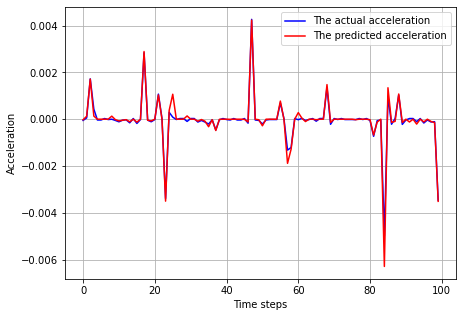

In [55]:
# Check the prediction result with training dataset

model = tf.keras.models.load_model("Models/FFNN.h5") # Load the trained FFNN
trainPredict = model.predict(x_train)

#plot prediction result
plt.figure(figsize=(7,5))
plt.plot(trainPredict[3900:4000,0]*0.001, "b",label="The actual acceleration")
plt.plot(y_train[3900:4000]*0.001, "r", label="The predicted acceleration")
plt.legend()
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Acceleration")

# Calculate the MAE
error=np.abs(trainPredict[:,0]*0.001-y_train*0.001)
MAE1=np.mean(error)  # the mean absolute error
MAE2=np.mean(np.abs(y_train)) # the average angular acceleration value
print(MAE1)
print(MAE2)
a=MAE1/MAE2
a

8.714761654194891e-05
0.5340272934793188


0.00020990060945795522

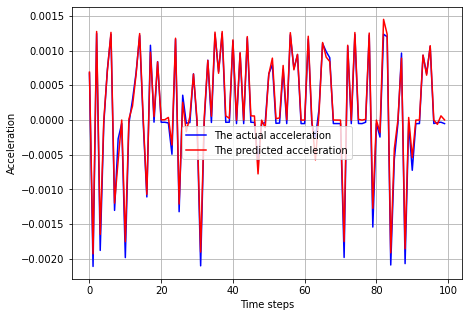

In [57]:
# Check the prediction result with training dataset

Valid_Predict = model.predict(x_valid)

plt.figure(figsize=(7,5))
plt.plot(Valid_Predict[3900:4000,0]*0.001, "b",label="The actual acceleration")
plt.plot(y_valid[3900:4000]*0.001, "r", label="The predicted acceleration")
#plt.plot(error[3900:4000], "y", label="error")
plt.legend()
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Acceleration")

Valid_error=np.abs(Valid_Predict[:,0]*0.001-y_valid*0.001)

Valid_MAE1=np.mean(Valid_error)  # the mean absolute error
Valid_MAE2=np.mean(np.abs(y_valid)) # the average angular acceleration value
print(Valid_MAE1)
print(Valid_MAE2)
a=MAE1/MAE2
a

# 5.1 Simulating angle sequence with the initial condition only.

0.0799249929881157


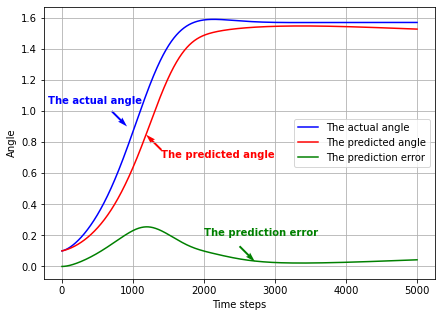

In [60]:
a_test=50
random_length=5000

x1=np.zeros((random_length)).squeeze() # "real" angle
x2=np.zeros((random_length)).squeeze() # "real" angular
x1_test=np.zeros((1, random_length)).squeeze()  # predicted angle
x2_test=np.zeros((1,random_length)).squeeze()  # predicted angular velocity

#Initialize the angle and angular velocity
x1[0]=0.1
x1[1]=0.1001
x2[0]=(x1[1]-x1[0])/di 

x1_test[0]=x1[0]
x2_test[0]=x2[0]

#representive torque parameters
c1=4.2816e-7
c2=1.568
c3=5.7534

#get the "real" angle sequence
for t in range(random_length-1):
    hinput=a_test*1000/(4*np.pi)
    x1[t+1]=x1[t]+di*x2[t]
    x2[t+1]=x2[t]+di*(-c3*x2[t]+c2*np.cos(x1[t])+c1*hinput*abs(hinput)*np.sin(2*x1[t]))
      
model1 = tf.keras.models.load_model("Models/FFNN.h5")
dx1=np.zeros((1, random_length)).squeeze()  #The angular acceleration

#get the predicted angle sequence
for t in range(random_length-1):
    dx1[t]=model1.predict([[x1_test[t],x2_test[t],a_test]])
    x1_test[t+1]=x1_test[t]+x2_test[t]*di
    x2_test[t+1]=x2_test[t]+dx1[t]*di

error=np.abs(x1-x1_test) #Predition error
MAE_angle=np.mean(error) # The mean absolute error
print(MAE_angle)

 #plot figure
plt.figure(figsize=(7,5))
plt.plot(x1,"b",label="The actual angle ")
plt.plot(x1_test,"r", label="The predicted angle" )
plt.plot(error[:5000],"g",label="The prediction error")
plt.legend()
plt.text(-200,1.05,"The actual angle",weight="bold",color="blue")
plt.quiver(700, 1, 1, -1, color='b', width=0.005)
plt.text(1400,0.7,"The predicted angle",weight="bold",color="r")
plt.quiver(1400, 0.75, -1, 1, color='r', width=0.005)
plt.text(2000,0.2,"The prediction error",weight="bold",color="g")
plt.quiver(2500, 0.13, 1, -1, color='g', width=0.005)
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Angle")

plt.savefig("Figures/angle.png")

# 5.2 Simulating angle sequence with the initial condition and feedback.

0.02516052259802949


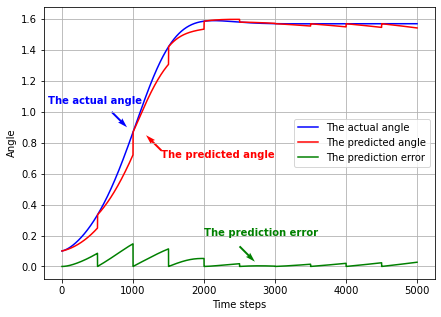

In [59]:
a_test=50
random_length=5000

x1=np.zeros((random_length)).squeeze() # "real" angle
x2=np.zeros((random_length)).squeeze() # "real" angular
x1_test_f=np.zeros((1, random_length)).squeeze()  # predicted angle with feedback
x2_test_f=np.zeros((1,random_length)).squeeze()  # predicted angular velocity with feedback
#Initialize the angle and angular velocity
x1[0]=0.1
x1[1]=0.1001
x2[0]=(x1[1]-x1[0])/di 

x1_test_f[0]=x1[0]
x2_test_f[0]=x2[0]

#representive torque parameters
c1=4.2816e-7
c2=1.568
c3=5.7534

#get the "real" angle sequence
for t in range(random_length-1):
    hinput=a_test*1000/(4*np.pi)
    x1[t+1]=x1[t]+di*x2[t]
    x2[t+1]=x2[t]+di*(-c3*x2[t]+c2*np.cos(x1[t])+c1*hinput*abs(hinput)*np.sin(2*x1[t]))
    


model1 = tf.keras.models.load_model("Models/FFNN.h5") 
dx1=np.zeros((1, random_length)).squeeze()

for t in range(random_length-1):
    dx1[t]=model1.predict([[x1_test_f[t],x2_test_f[t],a_test]])
    x1_test_f[t+1]=x1_test_f[t]+x2_test_f[t]*di
    x2_test_f[t+1]=x2_test_f[t]+dx1[t]*di
    x1_test_f[1:5000:500]=x1[1:5000:500] # Using the feedback information (angle)
    
error_f=np.abs(x1-x1_test_f) #Predition error with feedback
MAE_angle_f=np.mean(error_f) # The mean absolute error with feedback
print(MAE_angle_f)

 #plot figure
plt.figure(figsize=(7,5))
plt.plot(x1,"b",label="The actual angle ")
plt.plot(x1_test_f,"r", label="The predicted angle" )
plt.plot(error_f[:5000],"g",label="The prediction error")
plt.legend()
plt.text(-200,1.05,"The actual angle",weight="bold",color="blue")
plt.quiver(700, 1, 1, -1, color='b', width=0.005)
plt.text(1400,0.7,"The predicted angle",weight="bold",color="r")
plt.quiver(1400, 0.75, -1, 1, color='r', width=0.005)
plt.text(2000,0.2,"The prediction error",weight="bold",color="g")
plt.quiver(2500, 0.13, 1, -1, color='g', width=0.005)
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Angle")

plt.savefig("Figures/angle_feedback.png")
 